In [1]:
import itertools
import multiprocessing
import os
import re
import sys
from collections import Counter, defaultdict
from datetime import datetime
from itertools import groupby
from math import isclose

import en_core_web_lg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import wordninja
from gensim.models import Word2Vec
from IPython.display import HTML, display
from node2vec import Node2Vec as n2v
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from stellargraph import StellarGraph, datasets
from stellargraph.data import BiasedRandomWalk, EdgeSplitter
from thefuzz import fuzz
from tqdm import tqdm

from knowledge_layer import KnowledgeGroupLayer

input_dir = "/logs/"  # The input directory of log file
output_dir = "LogParserResult/"  # The output directory of parsing results

In [2]:
def remove_repeated(val):
    x = val.split(" ")
    str_list = list(filter(None, x))
    clean = [i[0] for i in groupby(str_list)]
    return " ".join(clean)


def preprocess_document(document):
    dic_debug = {}
    nlp = en_core_web_lg.load()
    # log_list =  [re.sub(r"[^A-Za-z]+", ' ', _) for _ in document]
    for log in document:
        splitted_log = wordninja.split(log.lower().rstrip())
        remove_urls = re.sub("[^ ]+\.[^ ]+", "<*>", " ".join(splitted_log))

        remove_float = re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)", "<*>", remove_urls)
        remove_int = re.sub(r"\d+", "<*>", remove_float)
        generic_str = re.sub(r"\b\w{1,2}\b", "", remove_int)

        dic_debug[log] = remove_repeated(generic_str)
    logs_clean = dic_debug.values()
    return logs_clean

In [3]:
def compute_generic_string(dataset):
    # edge case where all strings are the same
    if len(set(dataset)) == 1:
        return dataset[0]
    commonprefix = os.path.commonprefix(dataset)

    return "{}<*> {}".format(
        commonprefix,
        os.path.commonprefix([s[len(commonprefix) :][::-1] for s in dataset])[::-1],
    )

In [4]:
def remove_repeated(val):
    x = val.split(" ")
    str_list = list(filter(None, x))
    clean = [i[0] for i in groupby(str_list)]
    return " ".join(clean)

In [5]:
def transform_wildcard(document):
    print("in wild card step")
    logs_clean = list(set(document))  # remove repeated logs

    logs_dict = {}
    for doc1, doc2 in tqdm(
        itertools.combinations(logs_clean, 2), desc="processing similar logs"
    ):

        pair = [doc1, doc2]
        ratio = fuzz.ratio(doc1, doc2)
        if ratio > 70:
            c = compute_generic_string(pair)
            # generic_str = re.sub(r'\b\w{1,2}\b', '', c)

            if c not in logs_dict.values():
                p_string = remove_repeated(c)
                logs_dict[doc1] = p_string
                logs_dict[doc2] = p_string

        else:
            if doc1 not in logs_dict.keys():
                logs_dict[doc1] = remove_repeated(doc1)

            if doc2 not in logs_dict.keys():
                logs_dict[doc2] = remove_repeated(doc2)

    return list(set(logs_dict.values()))


temp = [
    "Block broadcast_9 stored as values in memory (estimated size 8.8 KB, free 14.0 KB)",
    "Block broadcast_8 stored as values in memory (estimated size 281.6 KB, free 317.0 KB)",
    "Block broadcast_2 stored as values in memory (estimated size 384.0 B, free 319.4 KB)",
    "Block broadcast_12 stored as values in memory (estimated size 9.8 KB, free 369.3 KB)",
    "Saved output of task 'attempt_201706092018_0024_m_000003_1012' to hdfs://10.10.34.11:9000/pjhe/test/1/_temporary/0/task_201706092018_0024_m_000003",
]
pdoc = preprocess_document(temp)
transform_wildcard(pdoc)

in wild card step


processing similar logs: 1it [00:00, ?it/s]


['block broadcast <*> stored values memory estimated size <*> free <*>',
 "saved output task ' attempt <*> ' hdf <*> test <*> temporary <*> task <*>"]

In [6]:
def get_relations(document):

    # in our case, relations are bigrams in sentences
    bigrams = []
    nlp = en_core_web_lg.load()
    # for sent in document:

    new_dict = {}
    for doc1, doc2 in itertools.combinations(document, 2):
        if doc1 != doc2:
            pdoc1 = re.sub("[^a-zA-Z0-9]+", " ", doc1)
            pdoc2 = re.sub("[^a-zA-Z0-9]+", " ", doc2)

            pair = [doc1, doc2]
            pdoc1 = nlp(pdoc1)
            pdoc2 = nlp(pdoc2)
            # only add unique bigrams
            similarity = pdoc1.similarity(pdoc2)
            ratio = fuzz.ratio(doc1, doc2)
            print(pair, similarity, ratio)
            if similarity > 0.7 or ratio > 70:

                if pair not in bigrams:
                    bigrams.append(pair)

    return bigrams

In [7]:
def load_logs(log_file, regex, headers):
    """ Function to transform log file to dataframe
    """
    log_messages = dict()
    linecount = 0
    with open(log_file, "r") as fin:
        for line in tqdm(fin.readlines(), desc="load data"):
            try:
                linecount += 1
                match = regex.search(line.strip())
                message = dict()
                for header in headers:
                    message[header] = match.group(header)
                message["LineId"] = linecount
                log_messages[linecount] = message
            except Exception as e:
                pass
    return log_messages

In [8]:
benchmark_settings = {
    "HDFS": {
        "log_file": "HDFS/HDFS_2k.log",
        "log_format": "<Date> <Time> <Pid> <Level> <Component>: <Content>",
    },
    "claudia": {
        "log_file": "HDFS/HDFS_2k.log",
        "log_format": "<Date> <Time> <Pid> <Level> <Component>: <Content>",
    },
    "Hadoop": {
        "log_file": "Hadoop/Hadoop_2k.log",
        "log_format": "<Date> <Time> <Level> \[<Process>\] <Component>: <Content>",
    },
    "Spark": {
        "log_file": "Spark/Spark_2k.log",
        "log_format": "<Date> <Time> <Level> <Component>: <Content>",
    },
    "Zookeeper": {
        "log_file": "Zookeeper/Zookeeper_2k.log",
        "log_format": "<Date> <Time> - <Level>  \[<Node>:<Component>@<Id>\] - <Content>",
    },
    "BGL": {
        "log_file": "BGL/BGL_2k.log",
        "log_format": "<Label> <Timestamp> <Date> <Node> <Time> <NodeRepeat> <Type> <Component> <Level> <Content>",
    },
    "HPC": {
        "log_file": "HPC/HPC_2k.log",
        "log_format": "<LogId> <Node> <Component> <State> <Time> <Flag> <Content>",
    },
    "Thunderbird": {
        "log_file": "Thunderbird/Thunderbird_2k.log",
        "log_format": "<Label> <Timestamp> <Date> <User> <Month> <Day> <Time> <Location> <Component>(\[<PID>\])?: <Content>",
    },
    "Windows": {
        "log_file": "Windows/Windows_2k.log",
        "log_format": "<Date> <Time>, <Level>                  <Component>    <Content>",
    },
    "Linux": {
        "log_file": "Linux/Linux_2k.log",
        "log_format": "<Month> <Date> <Time> <Level> <Component>(\[<PID>\])?: <Content>",
    },
    "Andriod": {
        "log_file": "Andriod/Andriod_2k.log",
        "log_format": "<Date> <Time>  <Pid>  <Tid> <Level> <Component>: <Content>",
    },
    "HealthApp": {
        "log_file": "HealthApp/HealthApp_2k.log",
        "log_format": "<Time>\|<Component>\|<Pid>\|<Content>",
    },
    "Apache": {
        "log_file": "Apache/Apache_2k.log",
        "log_format": "\[<Time>\] \[<Level>\] <Content>",
    },
    "Proxifier": {
        "log_file": "Proxifier/Proxifier_2k.log",
        "log_format": "\[<Time>\] <Program> - <Content>",
    },
    "OpenSSH": {
        "log_file": "OpenSSH/OpenSSH_2k.log",
        "log_format": "<Date> <Day> <Time> <Component> sshd\[<Pid>\]: <Content>",
    },
    "OpenStack": {
        "log_file": "OpenStack/OpenStack_2k.log",
        "log_format": "<Logrecord> <Date> <Time> <Pid> <Level> <Component> \[<ADDR>\] <Content>",
    },
    "Mac": {
        "log_file": "Mac/Mac_2k.log",
        "log_format": "<Month>  <Date> <Time> <User> <Component>\[<PID>\]( \(<Address>\))?: <Content>",
    },
}

In [9]:
def generate_logformat_regex(logformat):
    """ Function to generate regular expression to split log messages
    """
    headers = []
    splitters = re.split(r"(<[^<>]+>)", logformat)
    regex = ""
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(" +", "\\\s+", splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip("<").strip(">")
            regex += "(?P<%s>.*?)" % header
            headers.append(header)
    regex = re.compile("^" + regex + "$")
    return headers, regex

In [10]:
def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10, 10))

    # define position of nodes in figure
    # G= nx.convert_node_labels_to_integers(G, first_label=0)

    pos = nx.nx_agraph.graphviz_layout(G)
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)

    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, "weight")

    # draw edge labels (if any)
    # nx.draw_networkx_nodes(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_nodes(G, pos)
    # plot the title (if any)
    plt.title(dataset + " Logs")

    plt.show()
    return

In [11]:
def build_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    # get graph nodes
    # df = co_occurrence(pdoc, 2)
    pdoc = transform_wildcard(pdoc)

    # print(pdoc)
    # get graph edges
    if "<*>" in pdoc:
        pdoc.remove("<*>")
    edges = get_relations(pdoc)
    # nodes = log_transformer(pdoc)
    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(pdoc)
    atrributes = Counter(pdoc)
    nx.set_node_attributes(G, atrributes, "count")
    # G.remove_node('idf_weights')
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

In [12]:
dataset = "HDFS"
filepath = "../log_parser/logs/" + benchmark_settings[dataset]["log_file"]
print("Parsing file: " + filepath)
starttime = datetime.now()
headers, regex = generate_logformat_regex(benchmark_settings[dataset]["log_format"])
log_messages = load_logs(filepath, regex, headers)
log_messages = KnowledgeGroupLayer(log_messages).run()
# log_messages = DictGroupLayer(log_messages).run()
# preprocess layer
list_dict = log_messages.values()
empty_dict = {}
logs = [d.get("Content", None) for d in list_dict]

# print(logs[0:2])
G = build_graph(logs)

Parsing file: ../log_parser/logs/HDFS/HDFS_2k.log


priori knowledge preprocess: 100%|██████████| 2000/2000 [00:00<00:00, 40749.29it/s]

Knowledge group layer finished.


in wild card step


processing similar logs: 190it [00:00, 95143.00it/s]


['packet responder <*> for block <*> terminating', 'deleting block <*> file had oop data current <*>'] 0.6371706254732095 38
['packet responder <*> for block <*> terminating', 'got exception while serving <*>'] 0.4740881956272536 36
['packet responder <*> for block <*> terminating', 'starting thread transfer block <*>'] 0.6482743563233002 48
['packet responder <*> for block <*> terminating', 'block name system allocate block user root rand <*> temporary task <*> part <*>'] 0.6951947391557659 42
['packet responder <*> for block <*> terminating', 'receiving block <*>'] 0.7476728713718086 40
['packet responder <*> for block <*> terminating', 'verification succeeded for <*>'] 0.541564358886131 37
['packet responder <*> for block <*> terminating', 'block name system delete <*> added invalid set'] 0.646380901858103 39
['packet responder <*> for block <*> terminating', 'block ask replicate <*> data node'] 0.7048765669718293 41
['packet responder <*> for block <*> terminating', 'block name sys

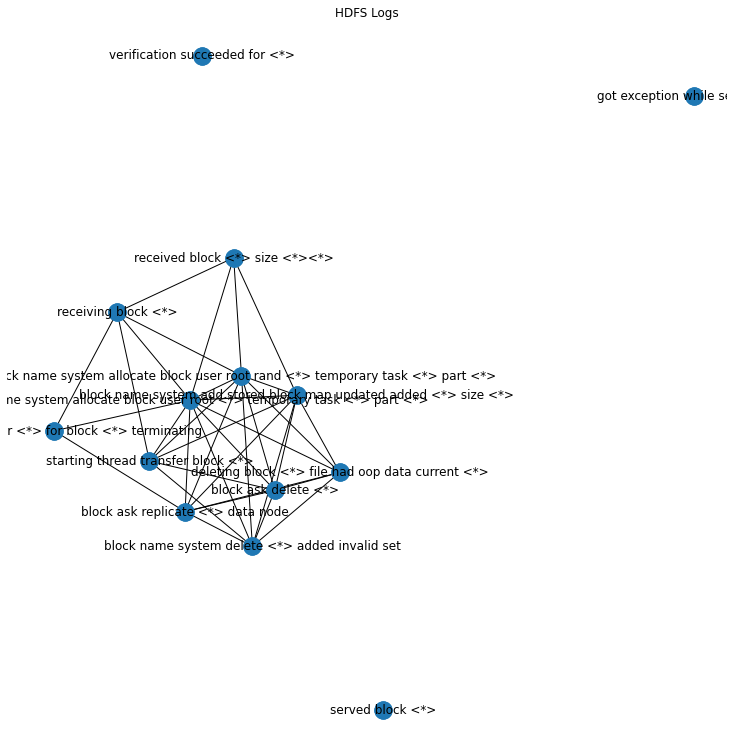

In [13]:
plot_graph(G)

In [15]:
nx.write_gpickle(G, "results/" + dataset + "sim.gpickle")

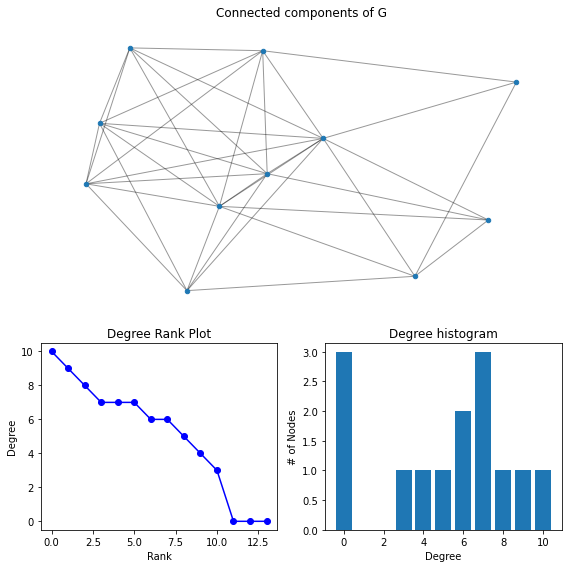

In [14]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [17]:
print(nx.info(G))

Graph with 16 nodes and 47 edges


In [18]:
g_emb = n2v(G, dimensions=16)

WINDOW = 1  # Node2Vec fit window
MIN_COUNT = 1  # Node2Vec min. count
BATCH_WORDS = 4  # Node2Vec batch words

mdl = g_emb.fit(window=WINDOW, min_count=MIN_COUNT, batch_words=BATCH_WORDS)

emb_df = pd.DataFrame(
    [mdl.wv.get_vector(str(n)) for n in G.nodes()], index=list(G.nodes())
)


emb_df.head()

print(emb_df.head())

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 19.99it/s]

                                                          0         1   \
received block <*> size <*><*>                     -0.188405  0.040160   
block name system delete <*> added invalid set     -0.182586  0.045615   
receiving block <*>                                -0.174112  0.067341   
served block <*>                                    0.022678 -0.014695   
block name system allocate block user root <*> ... -0.205622  0.058860   

                                                          2         3   \
received block <*> size <*><*>                     -0.033698  0.408059   
block name system delete <*> added invalid set      0.024454  0.406457   
receiving block <*>                                 0.026797  0.402107   
served block <*>                                   -0.025806  0.002967   
block name system allocate block user root <*> ... -0.030337  0.435741   

                                                          4         5   \
received block <*> size <*><*>      

In [20]:
WINDOW = 1  # Node2Vec fit window
MIN_COUNT = 1  # Node2Vec min. count
BATCH_WORDS = 4  # Node2Vec batch words

g_emb = n2v(G, dimensions=16)

mdl = g_emb.fit(window=WINDOW, min_count=MIN_COUNT, batch_words=BATCH_WORDS)

input_node = 'served block <*>'  
for s in mdl.wv.most_similar(input_node, topn=10):
    print(s)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 15.40it/s]

('got exception while serving <*>', 0.09298992156982422)
('block name system allocate block user root rand txt <*> temporary task <*> part <*>', 0.05150969326496124)
('block name system allocate block user root rand t<*> emporary task <*> part <*>', 0.03915339708328247)
('block name system allocate block user root <*> temporary task <*> part <*>', 0.036455392837524414)
('block ask delete <*>', 0.035970523953437805)
('received block <*> size <*><*>', 0.0346246063709259)
('receiving block <*>', 0.0328524112701416)
('block ask replicate <*> data node', 0.03229525685310364)
('starting thread transfer block <*>', 0.03185203671455383)
('block name system add stored block map updated added <*> size <*>', 0.026392877101898193)


In [22]:
graph = StellarGraph.from_networkx(G)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 16, Edges: 47

 Node types:
  default: [16]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [47]
        Weights: all 1 (default)
        Features: none


In [23]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 4 positive and 4 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 16, Edges: 43

 Node types:
  default: [16]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [43]
        Weights: all 1 (default)
        Features: none


In [24]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 4 positive and 4 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 16, Edges: 39

 Node types:
  default: [16]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [39]
        Weights: all 1 (default)
        Features: none


In [25]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,6,Train Graph,Test Graph,Train the Link Classifier
Model Selection,2,Train Graph,Test Graph,Select the best Link Classifier model
Test set,8,Test Graph,Full Graph,Evaluate the best Link Classifier


In [33]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [49]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=5, cv=2, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [41]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [42]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 160


In [43]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [50]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,1.0
operator_l1,1.0
operator_l2,1.0
operator_avg,1.0


In [51]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 160


In [53]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_hadamard': 0.5625


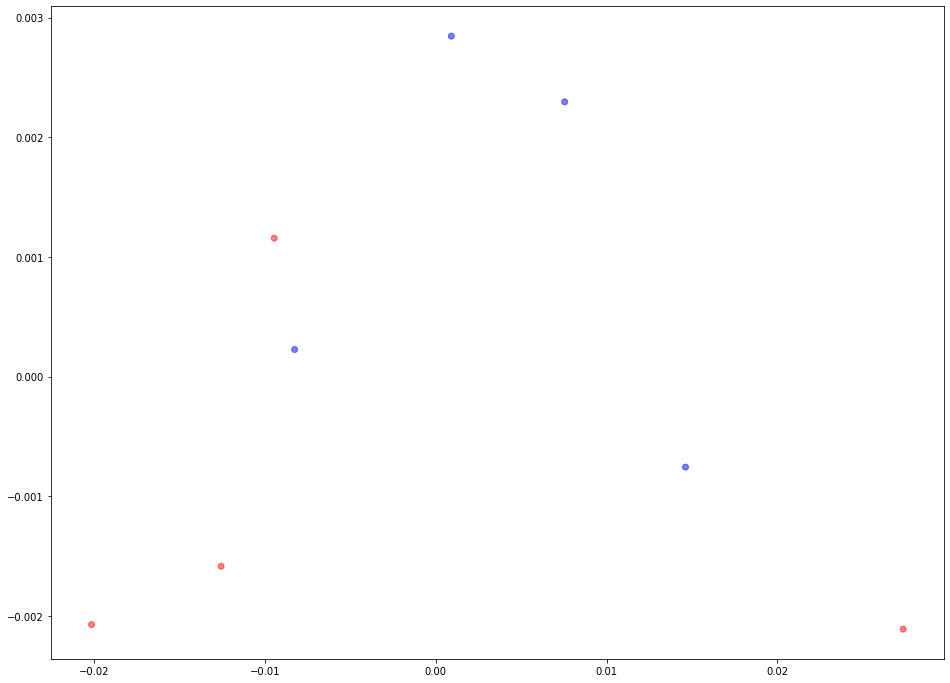

In [52]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)